In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import PIL
import cv2
from torch import nn
from torchvision import datasets, transforms, models
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)   

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg = vgg.to(device)
summary(vgg, (3, 244, 244))
vgg

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1,

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(img_path, max_size=400, shape=None):
    image = PIL.Image.open(img_path).convert("RGB")
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        #Set mean = 0.5, std deviation = 0.5
        #Chage range [0, 1] in image to [-1, 1] => (0-0.5)/0.5 = -1, (1-0.5)/0.5 = 1
        #(image - mean) / std
    ])
    image = in_transform(image).unsqueeze(0)
    return image

In [5]:
content = load_image('Images/City.jpg').to(device)
style = load_image('Images/StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [6]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0) #(1, 28, 28) to (28, 28, 1)
    #Change range from [-1, 1] back to [0, 1]. image * std + mean
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

(-0.5, 599.5, 399.5, -0.5)

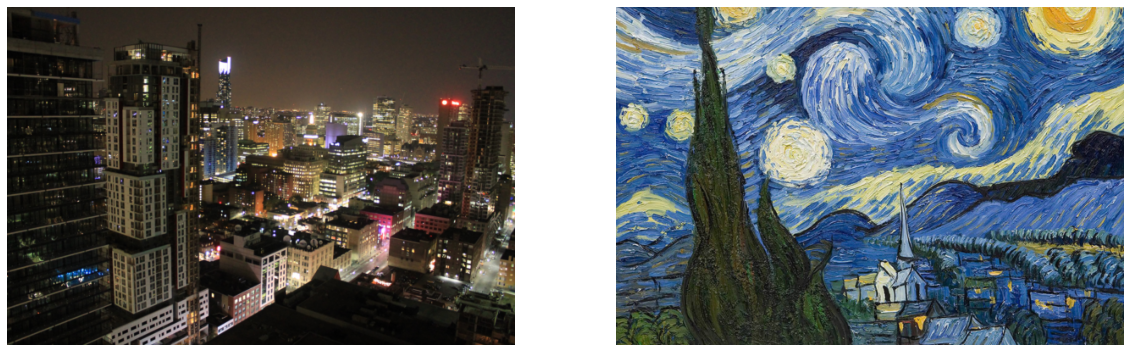

In [7]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [8]:
def get_features(image, model):
    #Content features can be found more easily in the 1st conv layer in each batch
    layers = {'0': "conv1_1",
              '5': "conv2_1",
              '10': "conv3_1",
              '19': "conv4_1",
              '21': "conv4_2", #Content extraction
              '28': "conv5_1"
             } 
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features

In [9]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [10]:
#Gram matrix, eliminate content information, see the 2nd paper
def gram_matrix(tensor):
    batch_size, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [11]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [12]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': .75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2
                }
content_weight = 1 #Alpha value
style_weight = 1e6 #Beta value

In [13]:
target = content.clone().requires_grad_(True).to(device)

In [14]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 10000
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  2887784.0
Iteration: 300/10000


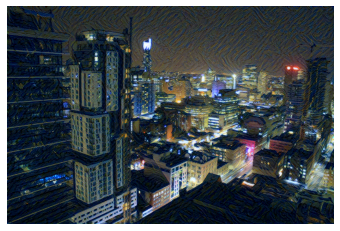

Total loss:  949846.6875
Iteration: 600/10000


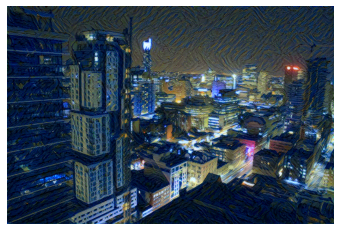

Total loss:  658561.4375
Iteration: 900/10000


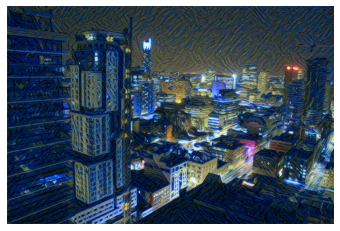

Total loss:  510601.6875
Iteration: 1200/10000


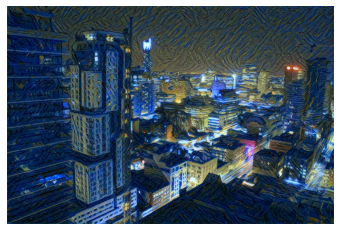

Total loss:  400877.15625
Iteration: 1500/10000


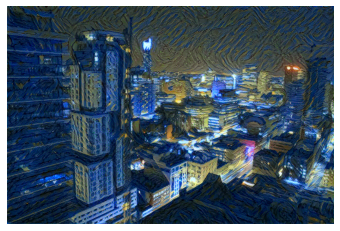

Total loss:  315012.4375
Iteration: 1800/10000


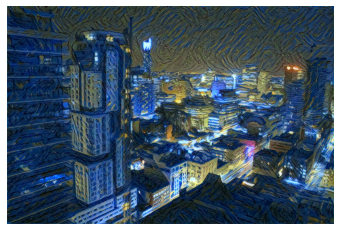

Total loss:  246957.234375
Iteration: 2100/10000


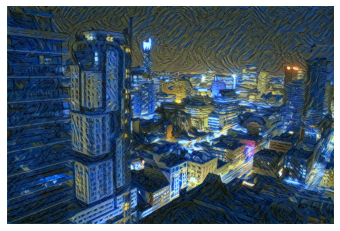

Total loss:  192675.265625
Iteration: 2400/10000


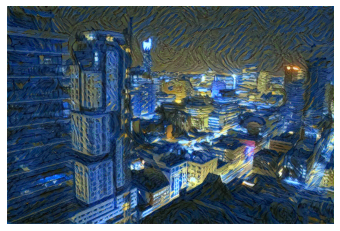

Total loss:  149457.6875
Iteration: 2700/10000


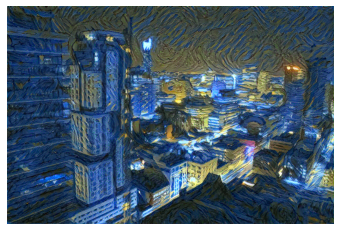

Total loss:  115337.125
Iteration: 3000/10000


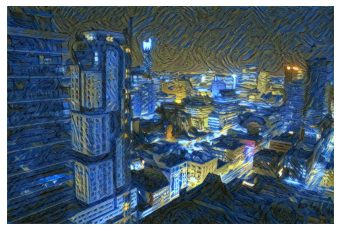

Total loss:  88764.1953125
Iteration: 3300/10000


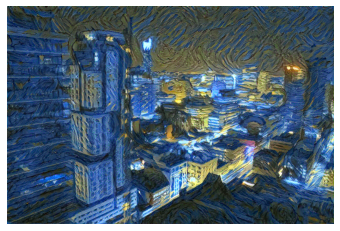

Total loss:  68395.703125
Iteration: 3600/10000


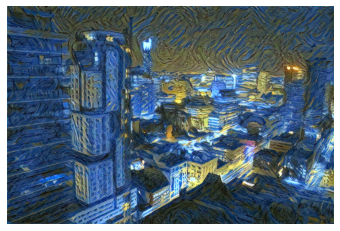

Total loss:  53099.5390625
Iteration: 3900/10000


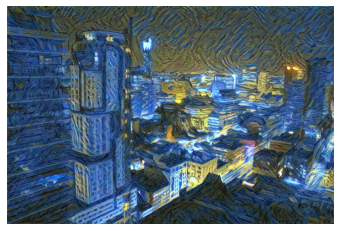

Total loss:  41838.25390625
Iteration: 4200/10000


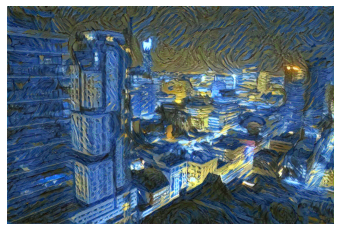

Total loss:  33665.984375
Iteration: 4500/10000


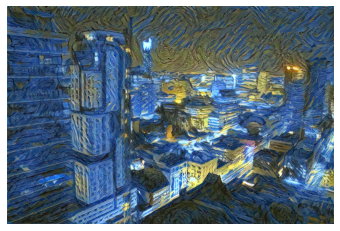

Total loss:  27778.908203125
Iteration: 4800/10000


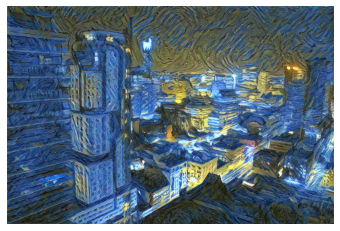

Total loss:  23535.59765625
Iteration: 5100/10000


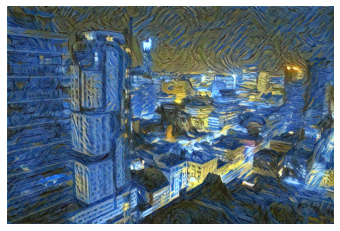

Total loss:  20496.3359375
Iteration: 5400/10000


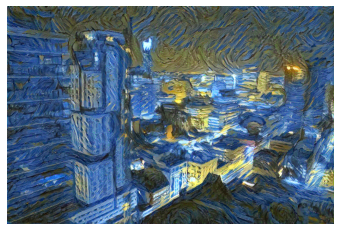

Total loss:  18241.244140625
Iteration: 5700/10000


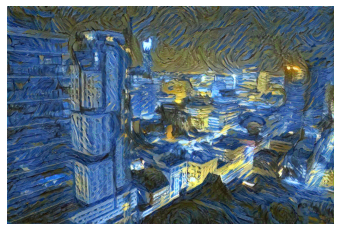

Total loss:  16869.24609375
Iteration: 6000/10000


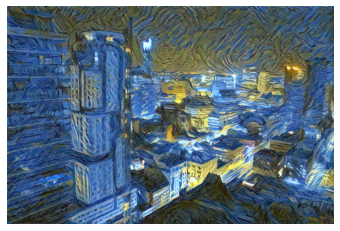

Total loss:  15269.060546875
Iteration: 6300/10000


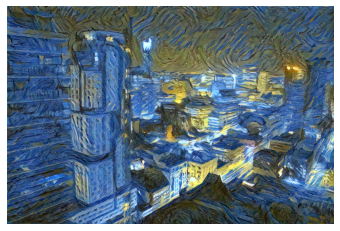

Total loss:  14928.28125
Iteration: 6600/10000


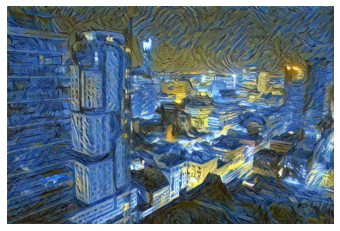

Total loss:  13637.0166015625
Iteration: 6900/10000


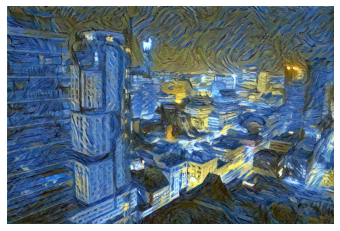

Total loss:  12920.5126953125
Iteration: 7200/10000


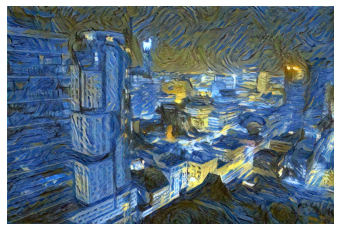

Total loss:  12381.546875
Iteration: 7500/10000


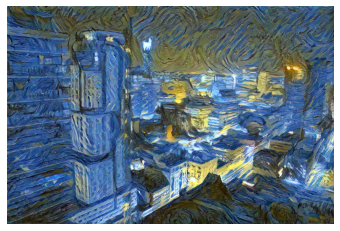

Total loss:  12617.9990234375
Iteration: 7800/10000


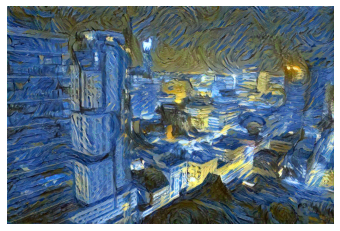

Total loss:  12538.9697265625
Iteration: 8100/10000


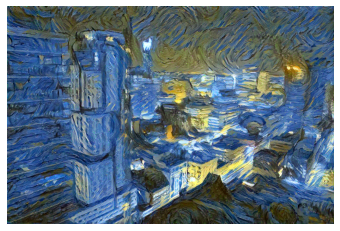

Total loss:  11000.2353515625
Iteration: 8400/10000


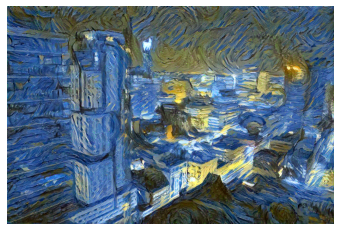

Total loss:  10732.68359375
Iteration: 8700/10000


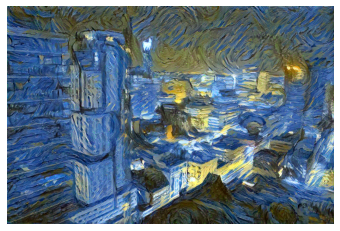

Total loss:  10445.8173828125
Iteration: 9000/10000


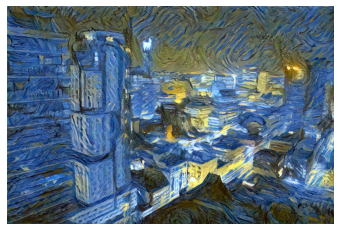

Total loss:  10269.1162109375
Iteration: 9300/10000


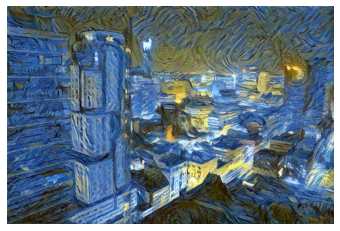

Total loss:  10046.724609375
Iteration: 9600/10000


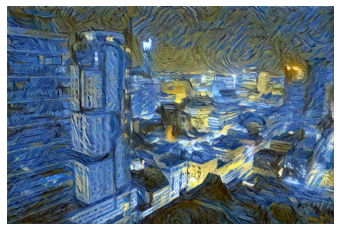

Total loss:  9752.6865234375
Iteration: 9900/10000


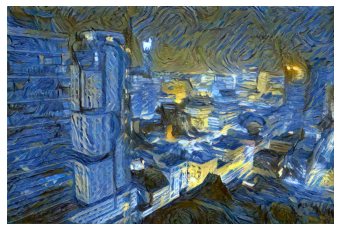

In [15]:
for ii in tqdm(range(1, steps+1), desc = "Total Progress"):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) #least mean square
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        batch_size, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: {}/{}'.format(ii, steps))
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter += 1

(-0.5, 599.5, 399.5, -0.5)

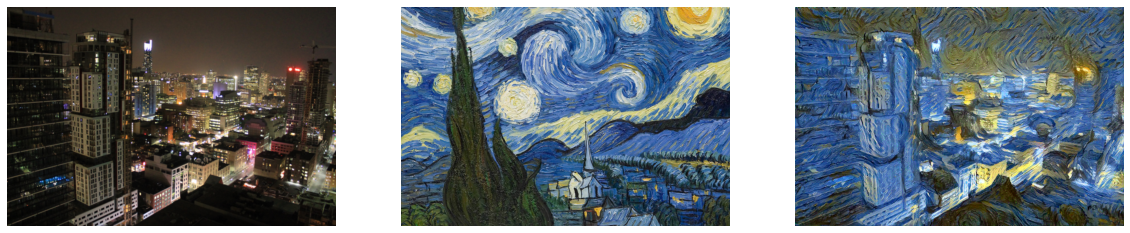

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [17]:
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()